In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import math
import random
import cellpylib as cpl
import numpy as np
import os
from IPython.display import HTML,display
import json
#%matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
plt.rcParams["animation.html"] = "jshtml"

## Helper Functions

### Visualization 

In [2]:
def animate(data):
    n_frames = len(data)

    dims = np.shape(data)
    colorsData = np.zeros(dims)
    for i in range(min(dims)):
        colorsData[i, i] = i
    fig = plt.figure()
    plot = plt.matshow(data[len(data)-1], fignum=0)

    def init():
        plot.set_data(data[0])
        return [plot]

    def update(j):
        plot.set_data(data[j])
        return [plot]


    anim = animation.FuncAnimation(fig, update, init_func = init, frames=n_frames, interval = 30, blit=True)

    return anim
    #plt.show()

### File Manipulation

In [3]:
def loadFromFolder(dirName,fmt="csv"):
    data = []
    count = 0
    if os.path.exists(dirName):
        for file in os.listdir(dirName):
            if ".{}".format(fmt) in file:
                data.append(pd.read_csv("{}/{}".format(dirName,file),header=None).values)
                count += 1
    else:
        print("{} directory not found in {}".format(dirName,os.getcwd()))
    print("loaded {} {} files from {}/{}.".format(len(data),fmt,os.getcwd(),dirName))
    return data

### Data Manipulation

In [4]:
def getDomain(data):
    #encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
    domain = {}
    for row in data:
        for j,col in enumerate(row):
            if j not in domain:
                domain[j] = []
            if col not in domain[j]:
                domain[j].append(col)
    for key in domain:
        domain[key].sort()
    return domain

## Loading previously generated automata

In [5]:
#Number of files
dirName = "data"
if os.path.exists(dirName):
    noFiles = len(os.listdir(dirName))
    print(noFiles)
else:
    print("path not found")

51


In [6]:
#load data without preprocessing
data = loadFromFolder(dirName)

loaded 50 csv files from /Users/hectormoreno/Documents/CIC/Tesis/Rule Discovery from Data for Cellular Automata/Method 6/data.


## Displaying automata

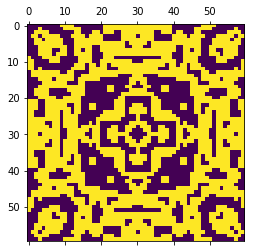

In [7]:
animate(data)

## Loading preprocessed automata

In [8]:
# load cleaned data
cleanPath = "clean"
clean = loadFromFolder(cleanPath)

loaded 29 csv files from /Users/hectormoreno/Documents/CIC/Tesis/Rule Discovery from Data for Cellular Automata/Method 6/clean.


## Loading Configuration

In [9]:
with open("config.json", "r") as read_file:
    config = json.load(read_file)

In [10]:
config

{'kernel': [[-1, -1],
  [0, -1],
  [1, -1],
  [-1, 0],
  [0, 0],
  [1, 0],
  [-1, 1],
  [0, 1],
  [1, 1]],
 'dimension': [60, 60],
 'paddingType': 1,
 'paddingValue': 0,
 'steps': 30}

In [11]:
kernel = config["kernel"]
dimension = config["dimension"]
paddingType = config["paddingType"]
paddingValue = config["paddingValue"]
steps = config["steps"]

## Getting Required Data

### Getting the domain of the automata for each attribute

In [12]:
domain = {}
for step in range(steps-1):
    stepDomain = getDomain(clean[step])
    for val in stepDomain:
        if val not in domain:
            domain[val] = set()
        for v in stepDomain[val]:
            domain[val].add(v)
domain

{0: {0, 1},
 1: {0, 1},
 2: {0, 1},
 3: {0, 1},
 4: {0, 1},
 5: {0, 1},
 6: {0, 1},
 7: {0, 1},
 8: {0, 1},
 9: {0, 1}}

## GA-Nuggets Helper functions

In [22]:
#individual format (ant,cons) where:
# ant = [[attrInd,val],...,[attrInd,val]]
# cons = [attrInd,val]

#Returns the number of active attributes in the antecedent
def getNumberOfAttributes(ant):
    count = 0;
    for attr in ant:
        if ant[1] != -1:
            count += 1
    return count

#Returns the interestingess degree 
#totalInfoGain = the summatory of the infoGain for each attribute in the antecedent
#noOfAttr = the number of attributes in the antecedent
#domainCardinality = the Cardinality of the goal attribute
def antInterestignessDegree(totalInfoGain,noOfAttr,domainCardinality):
    return 1 - ((totalInfoGain/noOfAttr)/math.log2(domainCardinality))


def consInterestignessDegree(consAttr,noEvents,beta):
    noFavEvents = noEvents[consAttr[0]][consAttr[0]][consAttr[1]][consAttr[1]]
    totalNoEvents = noEvents["totalNoEvents"]
    return 1 - math.pow( probability(noFavEvents,totalNoEvents),(1/beta) )

#returns the infoGain of an antecedent attribute with a given goal attribute
#attAnt = the antecedent attribute (pair of attr index and value)
#attCons = the consequent attribute (pair of attr index and value)
#domain = the domain of the attributes
#noEvents = tha total number of events for the probability calculation
def infoGain(attAnt,attCons,domain,noEvents):
    return info(domain,noEvents,attCons) - info(domain,noEvents,attCons,attAnt)

#returns the entropy of the goal attribute or the entropy ot he goal attribute given antecedent attribute
#domain = the domain of the attributes
#noEvents = tha total number of events for the probability calculation
#attCons = the consequent attribute (pair of attr index and value)
#attAnt = the antecedent attribute (pair of attr index and value)
def info(domain,noEvents,attCons,attAnt = None):
    res = 0
    if attAnt == None:
        for val in domain[attCons[0]]:
            noFavEvents = noEvents[attCons[0]][attCons[0]][val][val]
            totalNoEvents = noEvents["totalNoEvents"]
            pr = probability(noFavEvents,totalNoEvents)
            res += (pr*math.log2(pr))
        res = res * -1
    else:
        for val in domain[attAnt[0]]:
            totalNoEvents = noEvents["totalNoEvents"]
            noFavEvents = 0
            for gAttr in noEvents[attAnt[0]]:
                for gVal in noEvents[attAnt[0]][gAttr]:
                    noFavEvents += noEvents[attAnt[0]][gAttr][gVal][val]
            prAntAtt = probability(noFavEvents,totalNoEvents)
            sumCondInfo = 0
            for cVal in domain[attCons[0]]:
                probCA = probability(noEvents[attAnt[0]][attCons[0]][cVal][val],totalNoEvents)
                probA = probability(noFavEvents,totalNoEvents)
                condProb = probCA / probA
                sumCondInfo += (condProb*math.log2(condProb))
            sumCondInfo *= -1
            res += sumCondInfo * prAntAtt
    return res
            

def probability(noFavEvents,noEvents):
    return noFavEvents/noEvents

#Calculate the number of events given each possible value of the goal attributes indexes specified
#goalAttributes = an array with the goal attributes
#domain = the domain of the attributes
#dataset = the dataset where the data that will be processed
def calculateNoEvents(goalAttributes,domain,dataset):
    noEventsC = {}
    noEvents = 0
    for step in dataset:
        noEvents += len(step)
    
    for attr in domain:
        noEventsC[attr] = {}
        for g in goalAttributes:
            noEventsC[attr][g] = {}
            for gval in domain[g]:
                noEventsC[attr][g][gval] = {}
                for val in domain[attr]:
                    noEventsC[attr][g][gval][val] = 0
    
    for step in dataset:
        for row in step:
            for attr in domain:
                val = row[attr]
                for g in goalAttributes:
                    gval = row[g]
                    noEventsC[attr][g][gval][val] += 1
    noEventsC["totalNoEvents"] = noEvents
    return noEventsC
        
#Returns the accuracy of the antecedent with the consequent
#ant = the array of attributes
#cons =  the attribute
#dataset = the data that will be processed
def predictionAccuracy(ant,cons,dataset):
    acCount = 0
    aCount = 0
    for step in dataset:
        for row in step:
            vAnt = True
            vCons = True
            for att in ant:
                vAnt = vAnt and (row[att[0]] == att[1] if att[1] != -1 else True)
            vCons = vCons and (row[cons[0]] == cons[1])
            if vCons and vAnt:
                acCount += 1
                aCount += 1
            elif vAnt:
                aCount += 1
    return (acCount - 1/2)/aCount

#Returns the fitnes of an individual
def fitness(w1,w2,beta,ant,cons,domain,noEvents,dataset):
    antInt = 0
    consInt = 0
    sumInfoGain = 0
    noAttr = 0
    for attr in ant:
        if attr[1] != -1:
            sumInfoGain += infoGain(attr,cons,domain,noEvents)
    
    noAttr = getNumberOfAttributes(ant)
    antInt = antInterestignessDegree(sumInfoGain,noAttr,len(domain[cons[0]]))
    consInt = consInterestignessDegree(cons,noEvents,beta)
    
    acc = predictionAccuracy(ant,cons,dataset)
    
    return ((w1*(antInt + consInt) / 2) + (w2 * acc)) / (w1 + w2)

def initialize(populationSize,antMinSize,antMaxSize,objAttrInd,domain,seed=-1):
    population = []
    if seed != -1:
        random.seed(seed)
    for i in range(populationSize):
        antSize = random.randint(antMinSize,antMaxSize)
        ant = [[i,-1] for i in range(len(domain)-1)]
        for j in range(antSize):
            attr = ant[j][0]
            val = random.randint(-1,max(domain[attr]))
            ant[j]= [attr,val]
        valC = random.randint(min(domain[objAttrInd]),max(domain[objAttrInd]))
        cons = [objAttrInd,valC]
        population.append([ant,cons])
    return population

def ganuggets(populationSize,antMinSize,antMaxSize,beta,w1,w2,mutationRate,dataset,domain,noEvents,seed):
    population = initialize(populationSize,antMinSize,antMaxSize,9,domain,seed)
    fitnessTbl = []
    for i in range(len(population)):
        fitnessTbl.append([i,fitness(w1,w2,beta,population[i][0],population[i][1],domain,noEvents,dataset)])
    while it < maxIter and fitGoalReached:
        it += 1
        sorted(fitnessTbl,key = lambda x: x[1],reverse = True)
    return fitnessTbl,population

## Global Parameters

In [14]:
beta = 2
w1 = 1
w2 = 2
antMaxSize = 7
antMinSize = 3
population = 10
mutationRate = .7

In [141]:
#create random population
#compute the fitness
#Repeat 
#select individuals based on fitness
#apply genetic operator to selected individuals, creating offspring
#compute fitness of each offspring individual
#update current population
#until stopping criterion

(29, 60, 60)

In [24]:
noEvents = calculateNoEvents([9],domain,clean)

In [331]:
fit,pop = ganuggets(population,antMinSize,antMaxSize,beta,w1,w2,mutationRate,clean,domain,noEvents,100)

In [334]:
pop[sorted(fit,key = lambda x: x[1],reverse = True)[0][0]]

[[[5, -1], [8, -1], [5, 0], [8, 1], [5, 0], [7, 0], [6, -1]], [9, 1]]

In [23]:
initialize(population,antMinSize,antMaxSize,9,domain)

[[[[0, 1],
   [1, 1],
   [2, 1],
   [3, -1],
   [4, -1],
   [5, -1],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 1]],
 [[[0, -1],
   [1, -1],
   [2, -1],
   [3, -1],
   [4, 1],
   [5, 0],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 0]],
 [[[0, -1],
   [1, 0],
   [2, -1],
   [3, 1],
   [4, 1],
   [5, -1],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 0]],
 [[[0, -1],
   [1, 0],
   [2, 1],
   [3, 1],
   [4, -1],
   [5, -1],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 0]],
 [[[0, -1],
   [1, 1],
   [2, 1],
   [3, 0],
   [4, 0],
   [5, -1],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 1]],
 [[[0, 0], [1, -1], [2, 1], [3, 0], [4, 0], [5, 0], [6, 1], [7, -1], [8, -1]],
  [9, 0]],
 [[[0, -1],
   [1, -1],
   [2, -1],
   [3, -1],
   [4, -1],
   [5, -1],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 0]],
 [[[0, 0],
   [1, 1],
   [2, -1],
   [3, -1],
   [4, -1],
   [5, 0],
   [6, -1],
   [7, -1],
   [8, -1]],
  [9, 1]],
 [[[0, 0],
   [1, -1],
   [2, -1],
   [3, 1],
   [4, -1],
   [5, 1],
   [6, 0],
   [7, -